In [1]:
import matplotlib.pyplot as plt
import urllib.request
import zipfile
import numpy as np
from IPython.display import Image


import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

In [2]:
# from PIL import Image
# from tqdm import tqdm
# import glob
 
# filename_list = glob.glob("C:/Users/yeani/Desktop/size_test/original/*.jpg")
# filename_list.sort()
 
# fill_number = len(str(len(filename_list)))
# for idx, filename in enumerate(tqdm(filename_list), 1):
#     im = Image.open(filename)
#     area = (160, 40, 370, 80)
#     crop_image = im.crop(area)
#     savename = 'C:/Users/yeani/Desktop/size_test/test_crop/' + str(idx).zfill(fill_number) + '.jpg'
#     crop_image.save(savename)

In [3]:
TRAINING_DIR = "C:/Users/yeani/Desktop/size_test/test_crop"

In [4]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=0,
    width_shift_range=0,
    height_shift_range=0,
    shear_range=0,
    zoom_range=0,
    horizontal_flip=False,
    fill_mode='nearest', 
    validation_split=0.2
    )

In [5]:
training_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=128, 
                                                          target_size=(40, 210), 
                                                          class_mode='categorical', 
                                                          subset='training',
                                                         )

Found 96 images belonging to 6 classes.


In [6]:
validation_generator = training_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=128, 
                                                          target_size=(40, 210), 
                                                          class_mode='categorical',
                                                          subset='validation', 
                                                         )

Found 24 images belonging to 6 classes.


오리지널 사진 파일
Found 120 images belonging to 6 classes.
(120, 40, 210, 3) (120, 6)
[0. 1. 0. 0. 0. 0.]


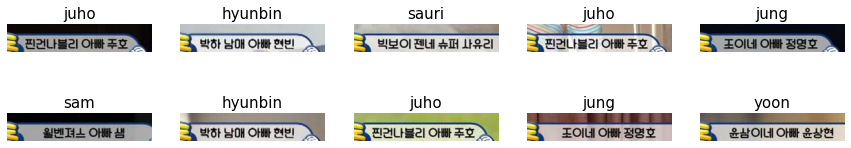

Augmentation 적용한 사진 파일
(96, 40, 210, 3) (96, 6)
[0. 0. 0. 0. 1. 0.]


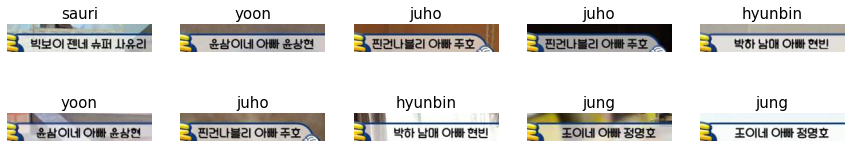

In [7]:
class_map = {
    0: 'hyunbin',
    1: 'juho',    
    2: 'jung',
    3: 'sam',
    4: 'sauri',
    5: 'yoon'
}

print('오리지널 사진 파일')

original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory(TRAINING_DIR, 
                                                          batch_size=128, 
                                                          target_size=(40, 210), 
                                                          class_mode='categorical'
                                                         )

for x, y in original_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 3)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    plt.show()
    break
    
print('Augmentation 적용한 사진 파일')
    
for x, y in training_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 3)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    
    plt.show()
    break

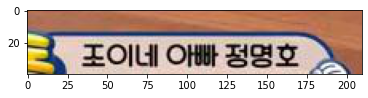

In [8]:
for x, y in original_generator:
    pic = x[:]
    break
    
plt.imshow(pic[0])

In [9]:
conv2d = Conv2D(64, (3, 3), input_shape=(40, 210, 3))
conv2d_activation = Conv2D(64, (3, 3), activation='relu', input_shape=(40, 210, 3))

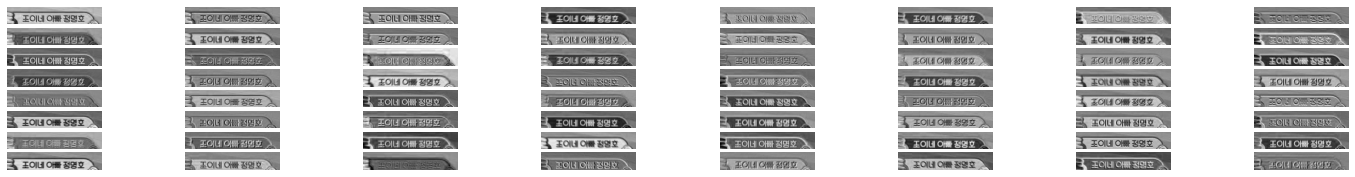

In [10]:
fig, axes = plt.subplots(8, 8)
fig.set_size_inches(25, 3)
for i in range(64):
    axes[i//8, i%8].imshow(conv2d(pic)[0,:,:,i], cmap='gray')
    axes[i//8, i%8].axis('off')

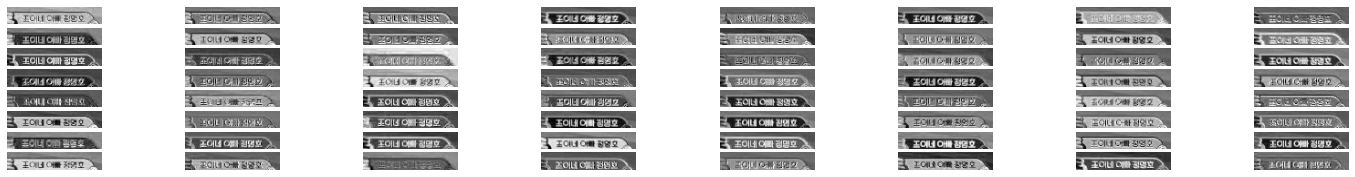

In [11]:
fig, axes = plt.subplots(8, 8)
fig.set_size_inches(25, 3)
for i in range(64):
    axes[i//8, i%8].imshow(MaxPooling2D(2, 2)(conv2d(pic))[0, :, :, i], cmap='gray')
    axes[i//8, i%8].axis('off')

In [12]:
conv1 = Conv2D(64, (3, 3), input_shape=(40, 210, 3))(pic)
max1 = MaxPooling2D(2, 2)(conv1)
conv2 = Conv2D(64, (3, 3))(max1)
max2 = MaxPooling2D(2, 2)(conv2)
conv3 = Conv2D(64, (3, 3))(max2)
max3 = MaxPooling2D(2, 2)(conv3)

fig, axes = plt.subplots(4, 1)
fig.set_size_inches(6, 12)
axes[0].set_title('Original', fontsize=20)
axes[0].imshow(pic[0])
axes[0].axis('off')
axes[1].set_title('Round 1', fontsize=20)
axes[1].imshow( conv1[0, :, :, 0], cmap='gray')
axes[1].axis('off')
axes[2].set_title('Round 2', fontsize=20)
axes[2].imshow( conv2[0, :, :, 0], cmap='gray')
axes[2].axis('off')
axes[3].set_title('Round 3', fontsize=20)
axes[3].imshow( conv3[0, :, :, 0], cmap='gray')
axes[3].axis('off')
plt.tight_layout()
plt.show()

In [13]:
model = Sequential([
    # Conv2D, MaxPooling2D 조합으로 층을 쌓습니다. 첫번째 입력층의 input_shape은 (이미지세로사이즈, 이미지가로사이즈, 3)으로 지정합니다.
    Conv2D(64, (3, 3), activation='relu', input_shape=(40, 210, 3)),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2), 
    # 2D -> 1D로 변환을 위하여 Flatten 합니다.
    Flatten(), 
    # 과적합 방지를 위하여 Dropout을 적용합니다.
    Dropout(0.5),
    Dense(512, activation='relu'),
    # Classification을 위한 Softmax 
    # 출력층의 갯수는 클래스의 갯수와 동일하게 맞춰줍니다 (6개), activation도 잊지마세요!
    Dense(6, activation='softmax'),
])

ValueError: Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling2d_67/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 1]](Placeholder)' with input shapes: [?,1,22,128].

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
checkpoint_path = "tmp_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [ ]:
epochs=25

In [ ]:
history = model.fit(training_generator, 
                    validation_data=(validation_generator),
                    epochs=epochs,
                    callbacks=[checkpoint],
                    )

In [ ]:
model.load_weights(checkpoint_path)


In [ ]:
# from keras.models import load_model
model.save('superman_model1.h5')

In [ ]:
plt.figure(figsize=(12, 9))
plt.plot(np.arange(1, epochs+1), history.history['acc'])
plt.plot(np.arange(1, epochs+1), history.history['loss'])
plt.title('Acc / Loss', fontsize=20)
plt.xlabel('Epochs')
plt.ylabel('Acc / Loss')
plt.legend(['acc', 'loss'], fontsize=15)
plt.show()